In [10]:
import weaviate
from weaviate.classes.query import MetadataQuery
from weaviate.exceptions import WeaviateQueryError
from weaviate.classes.init import AdditionalConfig, Timeout
import json
from tqdm import tqdm 
import time
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
import json
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
import re
from llm_calls import generation
from epsilon_estimation import estimate_optimal_epsilon


In [18]:
client.close()

In [6]:
def separate_clusters(labels, objects):
    # Create a dictionary to store objects in their respective clusters
    clusters = {}
    
    # Iterate over the labels and the corresponding objects
    for idx, label in enumerate(labels):
        label = int(label)
        # If label is not in the dictionary, add it
        if label not in clusters:
            clusters[label] = []
        # Append the object to the corresponding cluster
        clusters[label].append(objects[idx])
    
    return clusters

In [7]:
client = weaviate.connect_to_custom(
    http_host="weaviatedb.srv.webis.de",  
    http_port=80,                       
    http_secure=False,   
    grpc_host="weaviateinference.srv.webis.de",  
    grpc_port=80,                       
    grpc_secure=False,
    skip_init_checks=True,
    additional_config=AdditionalConfig(
        timeout=Timeout(init=1200, query=2400, insert=1200)  # Values in seconds
    )
)
collection=client.collections.get("Segments")


In [8]:
topics_file_path = '../Data/topics.rag24.test.txt'

topics = {}

with open(topics_file_path, 'r') as file:
    for line in file:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            topics[parts[0]] = parts[1]

topic_keys = list(topics.keys())

# Clustering Solution

In [9]:
output_file_path = './submissions/clustering_output.txt'
count = 0
#with open(output_file_path, 'w') as file:
for topic_id in topic_keys:
    count += 1
    query = topics[topic_id]
    response = collection.query.near_text(
                query=query,
                limit=100,
                return_metadata=MetadataQuery(distance=True, certainty=True)
            )
    # weirdly there was no way to retrieve the vector alongside 
    # the text and the metadata so i had to find a backdoor solution
    # by running another retrieval based on ids
    embs_to_cluster = []
    objects_retrieved = response.objects
    for o in tqdm(objects_retrieved):
        o_with_vector = collection.query.fetch_object_by_id(o.uuid, include_vector= True)
        embs_to_cluster.append(o_with_vector.vector['default'] )

    
    # May need to adjust eps for each query
    dbscan = DBSCAN(eps=0.1555, metric='cosine')
    labels = dbscan.fit_predict(embs_to_cluster)
    
    clusters = separate_clusters(labels, objects_retrieved)
    output = {"run_id": "buw", "topic_id": topic_id, "topic": query, "references": [], "response_length": 0, "answer": []}
    full_response = ""
    previous_info = ""
    turn_no = 1
    for label in clusters.keys():
        llm_response_dict = {"text": "", "citations": []}
        segment = clusters[label][0].properties['segment']
        docid = clusters[label][0].properties['docid']
        llm_response, previous_info = generation(query,[segment], turn_no,full_response, previous_info)
        full_response += " " + llm_response


        output["references"].append(docid)

        cite_idx = len(output["references"]) - 1
        llm_response_dict["text"] = llm_response
        llm_response_dict["citations"].append(cite_idx)
        output["answer"].append(llm_response_dict)

        output["response_length"] += len(llm_response.split())
        turn_no += 1
    
    #file.write(json.dumps(output, indent=4))
    if count == 1:
        print(previous_info)
        break

100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


 * Vicarious trauma is an ongoing process of change over time.
* It results from witnessing or hearing about other people’s pain and suffering.
* Personal reactions to traumatic material can be delayed.
* Listening to traumatic material can trigger memories of your own previous traumas.
* Vicarious trauma is similar to direct trauma, carrying many of the same symptoms and treated in many of the same ways.
* Medical providers, law enforcement, mental health staff, social workers, and those working in the courts are at risk of developing vicarious trauma symptoms.
* How one experiences vicarious trauma depends on personality, personal experience, life stressors, social support, and spiritual resources.
* Common reactions to vicarious trauma were not specified in the document. * Taking care of one's body, including getting enough sleep, eating healthy, and exercising regularly, can help in treating vicarious trauma
* Engaging in hobbies that make you feel good, practicing mindfulness or y

In [17]:
eps_values = np.linspace(0.1, 0.2, 10)
optimal_eps = estimate_optimal_epsilon(embs_to_cluster, eps_values)
print(f"Optimal epsilon: {optimal_eps}")
# May need to adjust eps for each query
dbscan = DBSCAN(eps=optimal_eps, metric='cosine')
labels = dbscan.fit_predict(embs_to_cluster)
labels

Optimal epsilon: None


In [50]:
output

{'run_id': 'buw',
 'topic_id': '2024-145979',
 'topic': 'what is vicarious trauma and how can it be coped with?',
 'references': ['msmarco_v2.1_doc_44_1043805224#2_2182641075',
  'msmarco_v2.1_doc_13_1647729865#6_3617408591',
  'msmarco_v2.1_doc_49_290196220#3_591257058',
  'msmarco_v2.1_doc_46_845296587#5_1805125294',
  'msmarco_v2.1_doc_54_1467297918#0_3111557199'],
 'response_length': 736,
 'answer': [{'text': ' Vicarious trauma is an ongoing process of change that develops over time as a result of witnessing or hearing about other people’s pain and suffering. It shares many symptoms and treatment methods with direct trauma. Those at risk include medical providers, law enforcement, mental health staff, social workers, and court staff. The experience of vicarious trauma can vary depending on personality, personal experience, life stressors, social support, and spiritual resources. Personal reactions to traumatic material can be delayed, and listening to such material can trigger memo

In [90]:
previous_info

" * Vicarious trauma results from witnessing or hearing about other people’s pain and suffering\n* Personal reactions to traumatic material can be delayed\n* Listening to traumatic material can trigger memories of previous traumas\n* Symptoms of vicarious trauma are similar to those of direct trauma and can include many of the same symptoms\n* Those at risk of developing vicarious trauma include medical providers, law enforcement, mental health staff, social workers, and court personnel\n* Experience of vicarious trauma depends on personality, personal experience, life stressors, social support, and spiritual resources\n* Common reactions to vicarious trauma are not specified in the document. * The treatment of vicarious trauma involves self-care for the body and mind\n* Self-care measures include getting enough sleep, eating healthy, and exercising regularly\n* Mindfulness and yoga are recommended for managing vicarious trauma\n* Seeking therapy is suggested as a way to treat vicariou

In [65]:
full_response

"  Vicarious trauma is a result of witnessing or hearing about other people’s pain and suffering, often affecting professionals such as medical providers, law enforcement, mental health staff, social workers, and court personnel. The personal reactions to vicarious trauma can be delayed and may vary depending on personality, personal experience, life stressors, social support, and spiritual resources. In some cases, listening to traumatic material can trigger memories of one’s own previous traumas. Experiencing vicarious trauma is similar to direct trauma, with many shared symptoms and treatment methods.  While it's crucial to take care of one's physical health by ensuring sufficient sleep, eating nutritiously, and staying active, addressing vicarious trauma also requires self-care for the mind. Engaging in activities that foster relaxation and introspection, such as practicing mindfulness or yoga, can greatly benefit those affected. Moreover, forming connections with family, friends, 

# Clustering Hyperparameter Tuning

100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


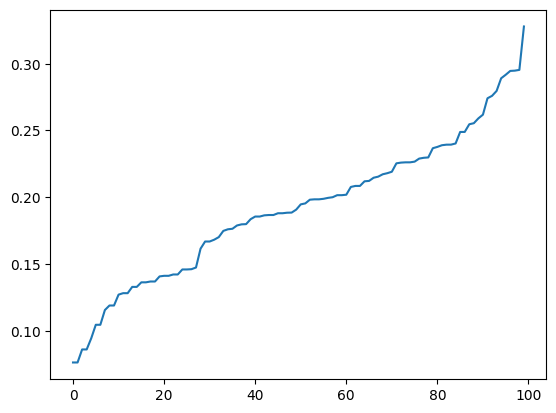

In [184]:
query = topics[topic_keys[2]]
response = collection.query.near_text(
            query=query,
            limit=100,
            return_metadata=MetadataQuery(distance=True, certainty=True)
        )
# weirdly there was no way to retrieve the vector alongside 
# the text and the metadata so i had to find a backdoor solution
# by running another retrieval based on ids
embs_to_cluster = []
objects_retrieved = response.objects
for o in tqdm(objects_retrieved):
    o_with_vector = collection.query.fetch_object_by_id(o.uuid, include_vector= True)
    embs_to_cluster.append(o_with_vector.vector['default'] )

neigh = NearestNeighbors(n_neighbors=2, metric="cosine")
nbrs = neigh.fit(embs_to_cluster)
distances, indices = nbrs.kneighbors(embs_to_cluster)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

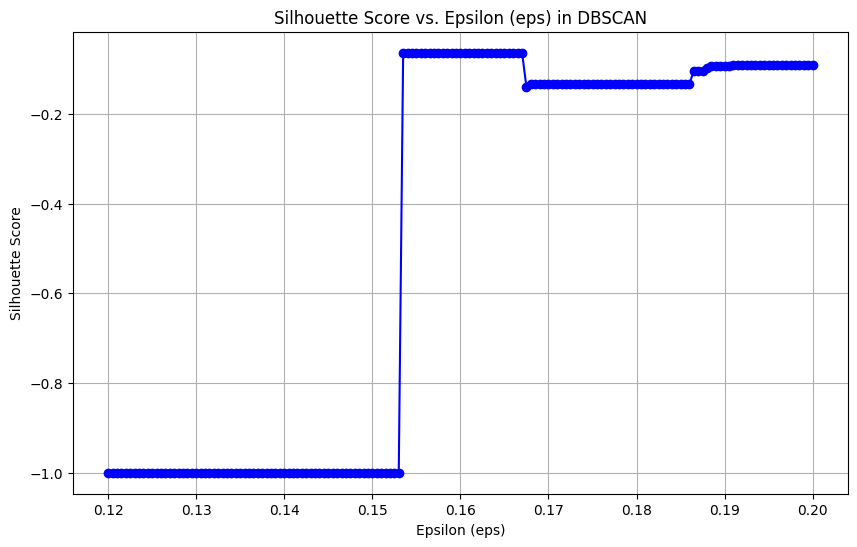

In [111]:
eps_values = np.arange(0.1200, 0.2000, 0.0005)
silhouette_scores = []

# Loop over the range of eps values
for eps in eps_values:
    # Create DBSCAN model with current eps
    dbscan = DBSCAN(eps=eps, metric='cosine')
    
    # Fit and predict clusters
    clusters = dbscan.fit_predict(embs_to_cluster)
    
    # Calculate silhouette score (only if there are at least 2 clusters)
    if len(set(clusters)) > 1:
        score = silhouette_score(embs_to_cluster, clusters, metric='cosine')
    else:
        score = -1  # Assign a low score if only one cluster is found
    
    # Store the score
    silhouette_scores.append(score)

# Plot the Silhouette scores against eps values
plt.figure(figsize=(10, 6))
plt.plot(eps_values, silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Epsilon (eps) in DBSCAN')
plt.grid(True)
plt.show()